In [ ]:
from google.colab import drive 
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/Bookpred/Assignment 2"
%cd {path}
!ls

import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

import scipy
from matplotlib import pyplot as plt
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.decomposition import PCA

Mounted at /content/drive
/content/drive/My Drive/Bookpred/Assignment 2
 8.prep_IMDB.ipynb
'Assignment 2 Track.gdoc'
 bert
 best_model
 book_rating_test.csv
 book_rating_train.csv
 book_text_features_countvec
 book_text_features_doc2vec
 book_text_features_tfidf
 COMP30027_Project2_spec_2023S1.pdf
'Copy of model.png'
 English
'English (1)'
'Feature engineering.ipynb'
 full_dataset
 history.pkl
 history_v.pkl
 lgbm_class_weight.joblib
 lgbm_cv.joblib
 lgbm_cw.joblib
 lgbm_normal.joblib
 lgbm_oversampling.joblib
 matrix.npz
 Model.ipynb
 model.png
 multilingual_best
 multilingual_epochs
 output.csv
 Oversampling
 Oversampling_real
 partition
 random_forest_doc.joblib
 random_forest.joblib
 random_forest_num.joblib
 rf_cw.joblib
 rf_normal.joblib
 rf_smote.joblib
 small_bert
 smallbert_class_weight.png
 smallbert_focal.png
 smallbert_normal.png
 smallbert_oversampling_minority.png
 Test
 test_focal.npy
 text_features_description.ipynb
 train_ind.pkl
 Validation
 val_ind.pkl
 val_output_sm

This notebook partially adopts certain code blocks from ChatGPT for visualization, model saving, loading, ... However, the core ideads are original; just run the LGBM parts

In [ ]:
# Norm + impute

train_df_orig = pd.read_csv("book_rating_train.csv")
test_df_orig = pd.read_csv("book_rating_test.csv")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_attribs = ['Publisher', 'PublishDay']
num_attribs = ["pagesNumber", "PublishYear"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs)
    ], remainder = 'drop')

num_df = full_pipeline.fit_transform(train_df_orig)
print(num_df.shape)

num_df_test = full_pipeline.transform(test_df_orig)
print(num_df_test.shape)

(23063, 4281)
(5766, 4281)


In [ ]:
import pickle

# load the list from the pickle file
with open('train_ind.pkl', 'rb') as f:
    train_ind = pickle.load(f)



# load the list from the pickle file
with open('val_ind.pkl', 'rb') as f:
    val_ind = pickle.load(f)
print(len(train_ind))  
print(len(val_ind))

18452
4611


In [ ]:
def convert_npz_train_val():
  val_name = scipy.sparse.load_npz(f'./partition/val/val_name_vec.npz')
  val_authors = scipy.sparse.load_npz(f'./partition/val/val_authors_vec.npz')
  val_desc = scipy.sparse.load_npz(f'./partition/val/val_desc_vec.npz')

  train_name = scipy.sparse.load_npz(f'./partition/train/train_name_vec.npz')
  train_authors = scipy.sparse.load_npz(f'./partition/train/train_authors_vec.npz')
  train_desc = scipy.sparse.load_npz(f'./partition/train/train_desc_vec.npz')

  test_name = scipy.sparse.load_npz(f'./partition/test/test_name_vec.npz')
  test_authors = scipy.sparse.load_npz(f'./partition/test/test_authors_vec.npz')
  test_desc = scipy.sparse.load_npz(f'./partition/test/test_desc_vec.npz')

  return val_name, val_authors, val_desc, train_name, train_authors, train_desc, test_name, test_authors, test_desc

val_name, val_authors, val_desc, train_name, train_authors, train_desc, test_name, test_authors, test_desc = convert_npz_train_val() 
print(train_name.shape)
print(train_authors.shape)
print(train_desc.shape)

print(val_name.shape)
print(val_authors.shape)
print(val_desc.shape)

print(test_name.shape)
print(test_authors.shape)
print(test_desc.shape)




(18452, 15296)
(18452, 11342)
(18452, 90674)
(4611, 15296)
(4611, 11342)
(4611, 90674)
(5766, 15296)
(5766, 11342)
(5766, 90674)


In [ ]:
from scipy.sparse import hstack
from sklearn.decomposition import TruncatedSVD


def create_dataset(train_name, val_name, test_name, train_authors, val_authors, test_authors, 
                   train_desc, val_desc, test_desc, num_df, num_df_test,
                   dimension_reduce = False, numerical = True):
  if numerical:
    train_df = hstack((num_df[train_ind, :], train_name, train_authors, train_desc))
    val_df = hstack((num_df[val_ind, :], val_name, val_authors, val_desc))
    test_df = hstack((num_df_test, test_name, test_authors, test_desc))





  # if dimension_reduce:
  #     # Create a TruncatedSVD object 
  #   svd = TruncatedSVD(100000)
  #   svd.fit(train_df)
  #   # print(svd.explained_variance_ratio_)
  #   cumsum = np.cumsum(svd.explained_variance_ratio_)
  #   # print(cumsum)
  #   dim = np.argmax(cumsum >= 0.95) + 1


  return train_df, val_df, test_df


train, val, test = create_dataset(train_name, val_name, test_name, train_authors, val_authors, test_authors, 
                   train_desc, val_desc, test_desc, num_df, num_df_test,
                   dimension_reduce = False, numerical = True)

print(train.shape)
print(val.shape)
print(test.shape)

(18452, 121593)
(4611, 121593)
(5766, 121593)


In [ ]:
import csv
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
 
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate(classifier, test_df = val, label_encoder = None, write_csv = False):
  y_pred = classifier.predict(test_df)
  if label_encoder:
    y_pred = classifier.predict(test_df)
    y_pred = label_encoder.inverse_transform(y_pred)
  def info(y_pred):
    print(np.unique(y_pred))
    print(pd.DataFrame(y_pred).value_counts())

  if write_csv: 
    # write in the csv file
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'rating_label'])
        for i, rating in enumerate(y_pred):
            writer.writerow([i+1, rating])

  info(y_pred)
  return y_pred

# RandomForest

In [ ]:


rfc = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 
                             None, max_features = 'auto', min_samples_leaf = 1,
                             min_samples_split= 3)

# lgbm = LGBMClassifier(class_weight = 'balanced')
rfc.fit(train, train_df_orig.iloc[train_ind, :]['rating_label'])

import csv

def evaluate(classifier, test_df = val, label_encoder = None, write_csv = False):
  y_pred = classifier.predict(test_df)
  if label_encoder:
    y_pred = classifier.predict(test_df)
    y_pred = label_encoder.inverse_transform(y_pred)
  def info(y_pred):
    print(np.unique(y_pred))
    print(pd.DataFrame(y_pred).value_counts())

  if write_csv: 
    # write in the csv file
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'rating_label'])
        for i, rating in enumerate(y_pred):
            writer.writerow([i+1, rating])

  info(y_pred)
  return y_pred
  

evaluate(rfc)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[3. 4. 5.]
4.0    4530
3.0      78
5.0       3
dtype: int64


array([4., 4., 4., ..., 4., 4., 4.])

[3. 4. 5.]
4.0    4530
3.0      78
5.0       3
dtype: int64


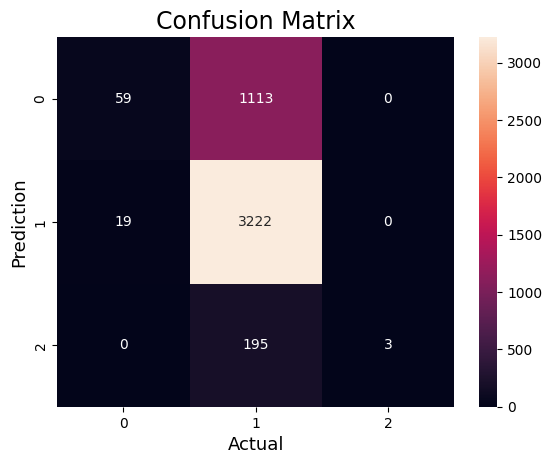

In [ ]:

#Import the necessary libraries
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
 
y_pred = evaluate(rfc, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

joblib.dump( rfc, "rf_normal.joblib",)
rfc = joblib.load("rf_normal.joblib")
print(classification_report(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred))


              precision    recall  f1-score   support

         3.0       0.76      0.05      0.09      1172
         4.0       0.71      0.99      0.83      3241
         5.0       1.00      0.02      0.03       198

    accuracy                           0.71      4611
   macro avg       0.82      0.35      0.32      4611
weighted avg       0.74      0.71      0.61      4611



## Class weights

In [ ]:
rfc = RandomForestClassifier( class_weight = 'balanced')

rfc.fit(train, train_df_orig.iloc[train_ind, :]['rating_label'])

joblib.dump( rfc, "rf_cw.joblib",)
rfc = joblib.load("rf_cw.joblib")

[3. 4. 5.]
4.0    4556
3.0      53
5.0       2
dtype: int64


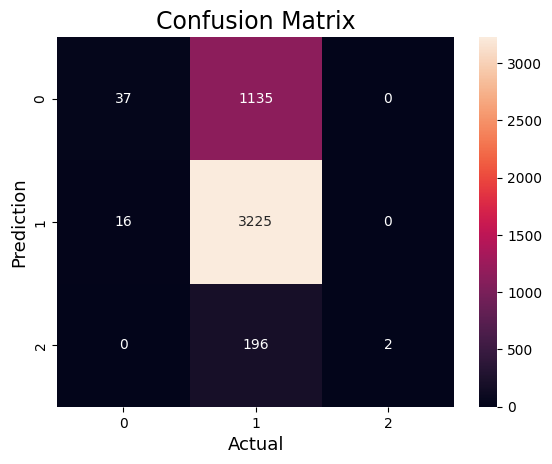

In [ ]:

y_pred = evaluate(rfc, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [ ]:
print(classification_report(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred))


              precision    recall  f1-score   support

         3.0       0.60      0.04      0.08      1172
         4.0       0.71      0.99      0.83      3241
         5.0       1.00      0.02      0.03       198

    accuracy                           0.71      4611
   macro avg       0.77      0.35      0.31      4611
weighted avg       0.69      0.71      0.60      4611



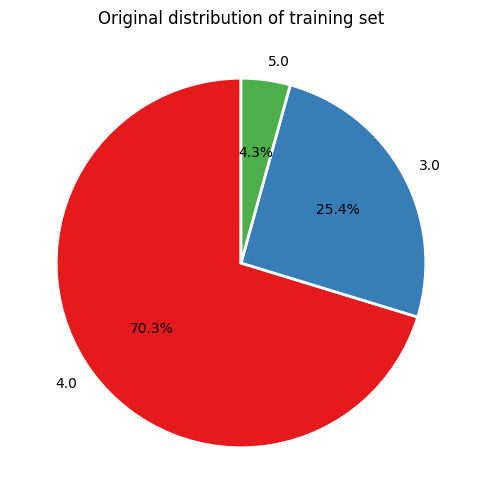

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# supported by chatgpt

# Create data
labels = ['4.0', '3.0', '5.0']
sizes = [16208/23063, 5864/23063, 991/23063]  # The proportion of each class in percent

# define colors for the pie slices
colors = ['red', 'blue', 'green']

# create the pie chart
plt.figure(figsize=(6,6))
sns.set_palette("Set1")
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90, wedgeprops={'linewidth':2,'edgecolor':'white'})
plt.title('Original distribution of training set')
plt.show()


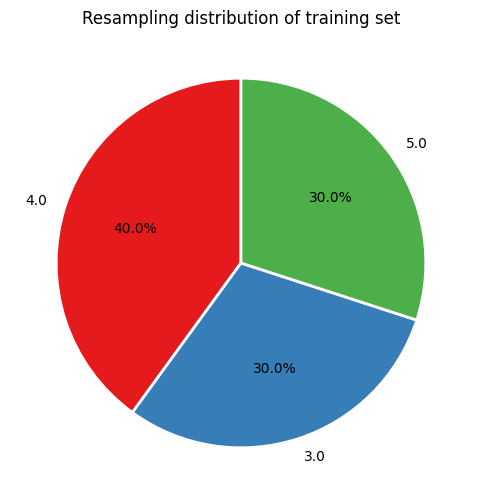

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# supported by chatgpt

# Create data
labels = ['4.0', '3.0', '5.0']
sizes = [0.4, 0.3, 0.3]  # The proportion of each class in percent

# define colors for the pie slices
colors = ['red', 'blue', 'green']

# create the pie chart
plt.figure(figsize=(6,6))
sns.set_palette("Set1")
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90, wedgeprops={'linewidth':2,'edgecolor':'white'})
plt.title('Resampling distribution of training set')
plt.show()


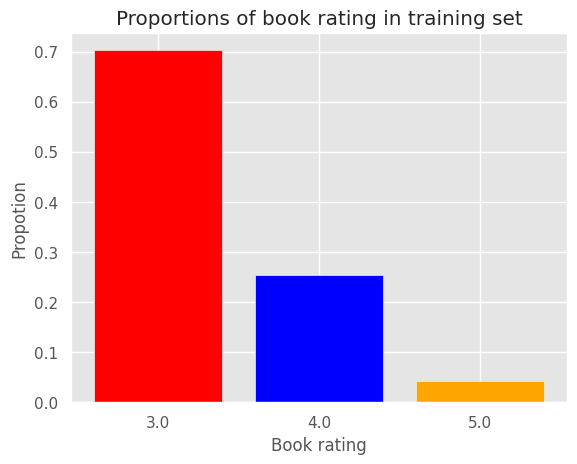

In [ ]:
# create the bar chart

# Create data
labels = ['3.0', '4.0', '5.0']
sizes = [16208/23063, 5864/23063, 991/23063]

import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure()

# sns.set_style("whitegrid")
plt.bar(labels, sizes, color = ['r', 'b', 'orange'])

# add labels and title
plt.xlabel("Book rating")
plt.ylabel("Propotion")
plt.title("Proportions of book rating in training set")

# show the chart
plt.show()

In [ ]:
print(len(train_df_orig))
train_df_orig['rating_label'].value_counts()

23063


4.0    16208
3.0     5864
5.0      991
Name: rating_label, dtype: int64

## SMOTE

In [ ]:
desired_freq= {3.0: 9750, 4.0: 13000, 5.0: 9750}
from imblearn.over_sampling import SMOTE


# Create an instance of SMOTE
sm = SMOTE(sampling_strategy = desired_freq, random_state=42)

# Fit the SMOTE object with X and y
# X_res, y_res = sm.fit_resample(train, train_df_orig.iloc[train_ind, :]['rating_label'])

# print(X_res.shape, y_res.shape)
# print(type(X_res), type(y_res))
import scipy.sparse as sp

# # assume you have a sparse CSR matrix named 'sparse_matrix'
# sp.save_npz('X_res.npz', X_res)

# # assume you have a Pandas series named 'pandas_series'
# y_res.to_csv('y_res.csv', index=False)

X_res = sp.load_npz('X_res.npz')
y_res = pd.read_csv('y_res.csv')


<ipython-input-16-631a7a58de61>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_res, y_res)


[3. 4. 5.]
4.0    4566
3.0      42
5.0       3
dtype: int64


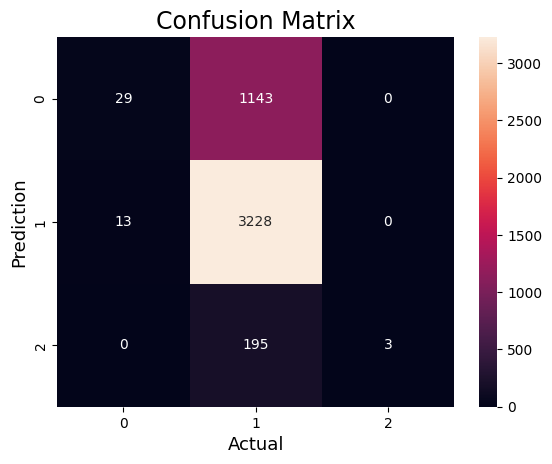

In [ ]:
rfc = RandomForestClassifier(random_state = 42)

rfc.fit(X_res, y_res)

joblib.dump( rfc, "rf_smote.joblib",)
rfc = joblib.load("rf_smote.joblib")

y_pred = evaluate(rfc, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# LGBM


## Cross-validation

[3. 4. 5.]
4.0    4321
3.0     274
5.0      16
dtype: int64


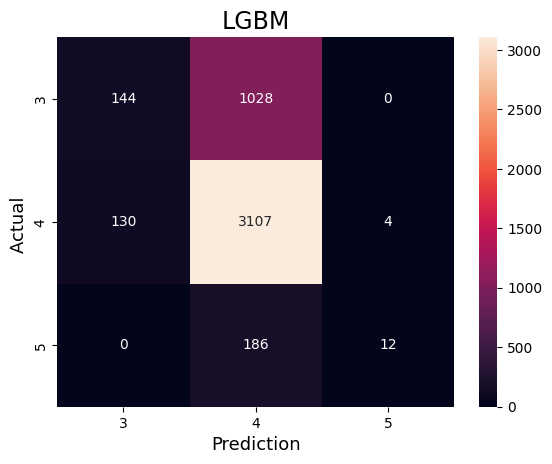

In [ ]:
from lightgbm import LGBMClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# lgbm = LGBMClassifier()
# lgbm.fit(train, train_df_orig.iloc[train_ind, :]['rating_label'])


# joblib.dump(lgbm, "lgbm_normal.joblib",)
lgbm = joblib.load("lgbm_cv.joblib")


def evaluate(classifier, test_df = val, label_encoder = None, write_csv = False):
  y_pred = classifier.predict(test_df)
  if label_encoder:
    y_pred = classifier.predict(test_df)
    y_pred = label_encoder.inverse_transform(y_pred)
  def info(y_pred):
    print(np.unique(y_pred))
    print(pd.DataFrame(y_pred).value_counts())

  if write_csv: 
    # write in the csv file
    with open('output.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'rating_label'])
        for i, rating in enumerate(y_pred):
            writer.writerow([i+1, rating])

  info(y_pred)
  return y_pred

y_pred = evaluate(lgbm, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
# chatgpt supported

#Plot the confusion matrix.
sns.heatmap(cm,
            annot=True,
            fmt='g',)
plt.ylabel('Actual ',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
# plt.xticks([3,4,5])
plt.xticks([0.5,1.5,2.5] , labels=['3', '4', '5'])
plt.yticks([0.5,1.5,2.5] , labels=['3', '4', '5'])
plt.title('LGBM',fontsize=17)
plt.show()

In [ ]:
y_pred = lgbm.predict(test)
evaluate(lgbm, test_df = test, write_csv = True)

[3. 4. 5.]
4.0    5416
3.0     328
5.0      22
dtype: int64


array([4., 4., 4., ..., 4., 4., 4.])

In [ ]:
print(classification_report(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred))


              precision    recall  f1-score   support

         3.0       0.53      0.12      0.20      1172
         4.0       0.72      0.96      0.82      3241
         5.0       0.75      0.06      0.11       198

    accuracy                           0.71      4611
   macro avg       0.66      0.38      0.38      4611
weighted avg       0.67      0.71      0.63      4611



In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score


print('Accuracy:', round(accuracy_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)*100,3))
print('F1 Score:', round(f1_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100,3))
print('Recall:', round(recall_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100, 3))
print('Precision:', round(precision_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100, 3))



Accuracy: 70.766
F1 Score: 63.303
Recall: 70.766
Precision: 67.119


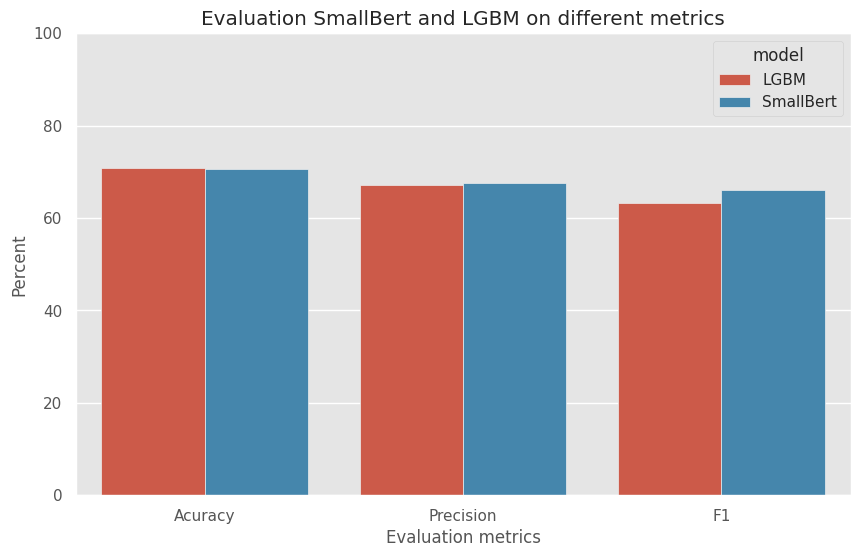

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# chatgpt supported
data = pd.DataFrame([
    ('Acuracy','LGBM',70.765),
    ('Acuracy','SmallBert',70.578),
    ('Precision','LGBM',67.119),
    ('Precision','SmallBert',67.613),
    ('F1','LGBM',63.302),
    ('F1','SmallBert',66.097),
], columns=['quarter', 'model', 'value'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='quarter', y='value', hue='model', data=data, ax=ax)
ax.set_xlabel('Evaluation metrics')
ax.set_ylabel('Percent')
ax.set_title('Evaluation SmallBert and LGBM on different metrics')
ax.set_ylim([0,100])
plt.show()


## Class weights

[3. 4. 5.]
4.0    2632
3.0    1625
5.0     354
dtype: int64


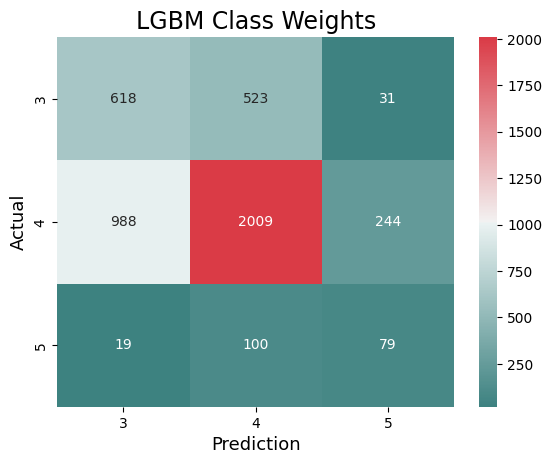

Accuracy: 58.686
F1 Score: 60.549
Recall: 58.686
Precision: 64.276


In [ ]:
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt
# lgbm = LGBMClassifier(class_weight = 'balanced')

# lgbm.fit(train, train_df_orig.iloc[train_ind, :]['rating_label'])


# joblib.dump(lgbm, "lgbm_cw.joblib",)
lgbm = joblib.load("lgbm_cw.joblib")



y_pred = evaluate(lgbm, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)
cmap = sns.diverging_palette(550, 10, as_cmap=True)

# chatgpt supported

 
#Plot the confusion matrix.
#Plot the confusion matrix.50
sns.heatmap(cm,
            annot=True,
            fmt='g', cmap = cmap)
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('LGBM Class Weights',fontsize=17)
plt.xticks([0.5,1.5,2.5] , labels=['3', '4', '5'])
plt.yticks([0.5,1.5,2.5] , labels=['3', '4', '5'])
plt.show()



print('Accuracy:', round(accuracy_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)*100,3))
print('F1 Score:', round(f1_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100,3))
print('Recall:', round(recall_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100, 3))
print('Precision:', round(precision_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100, 3))

## SMOTE

In [ ]:
# assume you have a sparse CSR matrix named 'sparse_matrix'
scipy.sparse.save_npz('X_res.npz', X_res)

# assume you have a Pandas series named 'pandas_series'
y_res.to_csv('y_res.csv', index=False)

In [ ]:
# chatgpt supported code for SMOTE resampling


# desired_freq= {3.0: 9750, 4.0: 13000, 5.0: 9750}
# from imblearn.over_sampling import SMOTE


# # Create an instance of SMOTE
# sm = SMOTE(sampling_strategy = desired_freq, random_state=42)

# # Fit the SMOTE object with X and y
# X_res, y_res = sm.fit_resample(train, train_df_orig.iloc[train_ind, :]['rating_label'])

/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (13000) in class 4.0 will be larger than the number of samples in the majority class (class #4.0 -> 12967)
  warnings.warn(


[3. 4. 5.]
4.0    4034
3.0     497
5.0      80
dtype: int64


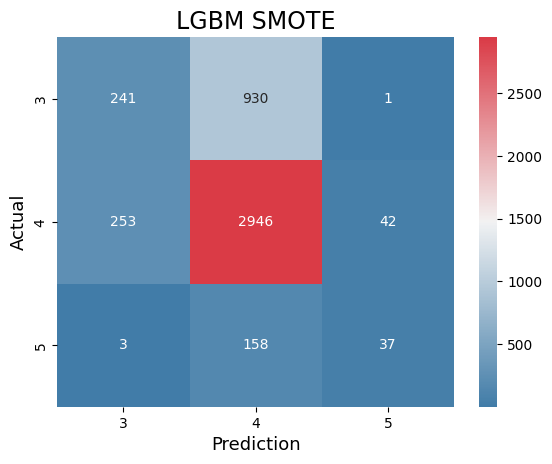

Accuracy: 69.92
F1 Score: 65.41
Recall: 69.92
Precision: 65.642


In [ ]:
lgbm = LGBMClassifier()
# lgbm.fit(X_res, y_res)


# joblib.dump( lgbm, "lgbm_oversampling.joblib",)
lgbm = joblib.load("lgbm_oversampling.joblib")

y_pred = evaluate(lgbm, val, write_csv = False)
cm = confusion_matrix(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)

 
#Plot the confusion matrix.
cmap = sns.diverging_palette(600, 10, as_cmap=True)

 
#Plot the confusion matrix.
#Plot the confusion matrix.50
sns.heatmap(cm,
            annot=True,
            fmt='g', cmap = cmap)
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('LGBM SMOTE',fontsize=17)
plt.xticks([0.5,1.5,2.5] , labels=['3', '4', '5'])
plt.yticks([0.5,1.5,2.5] , labels=['3', '4', '5'])
plt.show()

print('Accuracy:', round(accuracy_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred)*100,3))
print('F1 Score:', round(f1_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100,3))
print('Recall:', round(recall_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100, 3))
print('Precision:', round(precision_score(train_df_orig.iloc[val_ind, :]['rating_label'], y_pred, average='weighted')*100, 3))

In [ ]:
import scipy.sparse as sp


X_res = sp.load_npz('X_res.npz')
y_res = pd.read_csv('y_res.csv')